# 2.06 Chord Change

Now a chord model can be defined manually instead of one single scale. The Chord pattern is repeated. The chords change after six notes.

The chord changes gets improved in the version 2.07 2.08 and 2.10


In [41]:
from pyknon.genmidi import Midi
from pyknon.music import Rest, Note, NoteSeq
import numpy as np
import matplotlib.pyplot as plt

__Instruments:__
Available are at lest the 128 General-Midi (GM) Instruments. Depending on the sound-fonts there is a bigger choice. A list of the GM instruments can be found here. https://jazz-soft.net/demo/GeneralMidi.html


In [42]:
major = np.array([ 0, 2, 4, 5, 7, 9, 11])
minor = np.array([ 0, 2, 3, 5, 7, 8, 10])  
C7 = np.array([ 0, 4, 7, 10]) 
CM7 = np.array([ 0, 4, 7, 11])
Cm7 = np.array([ 0, 3, 7, 10])
Cm  = np.array([ 0, 3, 7])
C   = np.array([ 0, 4, 7])
bass= np.array([ 0])


def scale_create(tones):
    tones = np.asarray(tones)   # tones which form chord or scale in the first octave (0-11)
    if any(tones > 11):             # tones over one octave?
        tones = np.mod(tones,12)    # set the thones in one octave
        tones = np.sort(tones)      # sort the tones new
        tones = np.unique(tones)    # remove duplicate tones
    octave = np.repeat( np.linspace(0,108, num=10), len(tones))
    scale = np.add( octave, np.tile(tones, 10)) # add element wise octave and note
    return scale.astype(int)
    
def fade(start,end,steps): # currently not in use
    fade = np.around( np.linspace(start,end,num=steps))
    fade = fade.astype(int)
    return fade

def ran_duration(duration, prob_duration, melody_len):    
    duration= np.asarray(duration)                  # this are the allowed durations of the notes
    prob_duration = np.asarray(prob_duration)       # this are the probabilities how often each will occure
    prob_duration = prob_duration/np.sum(prob_duration) 
    rythem = np.r_[np.random.choice(duration, size=melody_len, p=prob_duration)]
    return rythem
    
def ran_volume(volume, prob_volume, melody_len):
    volume = np.asarray(volume, dtype=int)         # this are the allowed volumes of thenotes
    prob_volume = np.asarray(prob_volume)          # this are the probabilities how often each volume will occure
    prob_volume = prob_volume/np.sum(prob_volume) 
    volumes = np.r_[np.random.choice(volume, size=melody_len, p=prob_volume)]
    return volumes

def intvl_melody(intvl, prob_intvl, melody_len):  #Interval Melody   # currently not in use
    intvl = np.asarray(intvl)            # Possible interval
    prob_intvl = np.asarray(prob_intvl)         # Probability of each interval
    prob_intvl = prob_intvl/np.sum(prob_intvl)
    intervals = np.r_[np.random.choice(intvl, size=melody_len, p=prob_intvl)] 
    imelody = np.cumsum(intervals)
    return imelody

__linear_range:__
Generates an range in which the instrument can play. 


In [43]:
def liniar_range(r_start, r_top, r_edge, r_end, title): # acceptance range of the instrument 
    h = 100 # hight of acceptance function
    a_range = np.zeros(121, dtype=int)  # only to midi =120 as 127 is not a complete octave
    np.put(a_range, range(r_start,r_top),  np.linspace(0,h, num=(r_top -r_start)) )
    np.put(a_range, range(r_top, r_edge),  np.linspace(h,h, num=(r_edge-r_top  )) )
    np.put(a_range, range(r_edge, r_end),  np.linspace(h,0, num=(r_end -r_edge )) )
    
    fig, ax = plt.subplots()
    ax.plot(range(121), a_range)
    plt.title(str(title)+':  '+str([r_start, r_top, r_edge, r_end]))
    plt.show()
    return a_range
    

__i_last_note:__ finds the i value of the last note in the actual scale. 

In [44]:
def i_last_note(note, scale):
    i_note = (np.abs(scale - note)).argmin()
    return i_note

__intvl_next__ is a modification of intvl_melody. But it does only creates __one__ interval and not an array/melody in one time.

In [45]:
def intvl_next(intvl, prob_intvl):  #singel interval
    intvl = np.asarray(intvl)            # Possible interval
    prob_intvl = np.asarray(prob_intvl)         # Probability of each interval
    prob_intvl = prob_intvl/np.sum(prob_intvl)
    interval = np.random.choice(intvl, size=1, p=prob_intvl)
    return interval[0]

In [46]:
# x is the value in the aceptance range of the current note, while x_new is it from the proposoal note

def acceptance(x, x_new):
    if x_new < 1:
        if x < 1:
            print('start_note not in range')
            return 
    quot = x_new/x
    if quot >= 1: return True
    if np.random.uniform(0,1)< quot: return True
    else: return False
  

In [117]:
def acceptance_melody(intvl, prob_intvl, scales, start_note, a_range, melody_len):
    melody = np.zeros(melody_len, dtype=int)
    melody[0] = scales[0][i_last_note(start_note,scales[0])]

    scale_nr =0   
    for npn in range(1, melody_len):
        
        # -- scale changing ------
        if np.mod(npn,6)==0:   # number in mp.mod: how many tones in one scale
            scale_nr = scale_nr + 1
            if scale_nr >= len(scales):
                scale_nr =0       
        scale = scales[scale_nr]
        
        
        accept = False    
        while not accept:       # aslong acept == False
            inote = i_last_note(melody[npn-1],scale)
            inote_next = inote + intvl_next(intvl, prob_intvl)         # add current not with Proposition
            accept_val = a_range[[melody[(npn-1)],scale[inote_next]]]  # get acceptance values
            accept = acceptance(accept_val[0],accept_val[1])
        melody[npn] = scale[inote_next]
    return melody
            
        

__tune_Q:__  |I|VI|II|V| scheme

In [118]:
def tune_Q():
    tune_name = 'tune_Q'  
    #np.random.seed(23)
    melody_len = 60
    #scales = [scale_create(major),scale_create(minor)]
    scales = [scale_create(C),scale_create(Cm +9),scale_create(Cm+2),scale_create(C7+7)]  # I|VI|II|V|
    range_1 = liniar_range(55,65,80,93,'Range 1')
    
    melody1 = acceptance_melody([-2,-1, 0, 1, 2],[1, 3, 1, 3, 1],scales, 67, range_1, melody_len)
    rythem1 = ran_duration([1/8, 1/4,1/2], [3,2,1], melody_len)
    volumes1 = ran_volume([0,120], [0,8], melody_len )

    notes1 = NoteSeq( [Note(no,octave=0, dur=du, volume=vo) for no,du,vo in zip(melody1,rythem1,volumes1)] )

    
    instruments = [68]
    notes = [notes1]
    return notes, instruments,tune_name

__tune_R:__ Blues scheme with two voices. 

As the melody creating is independent for each voice, the chord changes is not simultaneously. This needs to be corrected.

In [129]:
def tune_R():
    tune_name = 'tune_R'  
    #np.random.seed(23)
    melody_len = 60
    #scales = [scale_create(C),scale_create(Cm +9),scale_create(Cm+2),scale_create(C7+7)]  # I|VI|II|V|
    #scales = [scale_create(major),scale_create(minor)]
    #scales = [scale_create(CM7),scale_create(Cm7+9),scale_create(Cm7+2),scale_create(C7+7)] #rythem Change
    scales = [scale_create(C7),scale_create(C7+5),scale_create(C7),scale_create(C7+7),scale_create(C7+5),scale_create(C7)] # Blues 
    
    range_1 = liniar_range(30,48,72,84, tune_name +' Range 1')
    melody1 = acceptance_melody([-2,-1, 0, 1, 2],[1, 3, 1, 3, 1],scales, 60, range_1, melody_len)
    rythem1 = ran_duration([1/8, 1/4,1/2], [4,2,1], melody_len)
    volumes1 = ran_volume([0,120], [2,8], melody_len )
    notes1 = NoteSeq( [Note(no,octave=0, dur=du, volume=vo) for no,du,vo in zip(melody1,rythem1,volumes1)] )
    
    range_2 = liniar_range(38,43,55,67,tune_name+ ' Range 2')
    melody2 = acceptance_melody([-2,-1, 0, 1, 2],[0, 3, 1, 3, 0],scales, 46, range_2, melody_len)
    rythem2 = ran_duration([1/8, 1/4,1/2], [4,2,1], melody_len)
    volumes2 = ran_volume([0,120], [0,8], melody_len )
    notes2 = NoteSeq( [Note(no,octave=0, dur=du, volume=vo) for no,du,vo in zip(melody2,rythem2,volumes2)] )


    
    instruments = [0,33]
    notes = [notes1,notes2]
    return notes, instruments,tune_name

In [130]:

def gen_midi():
#     squezze into a MIDI framework
    notes, instruments, tune_name = tune_R() #  <--- select a tune  <<--     <<<<<<<<<--- select a tune -----
    nTracks = len(notes)
    
    m = Midi(number_tracks=nTracks, tempo=120, instrument=instruments)
    for iTrack in range(nTracks):
        m.seq_notes(notes[iTrack], track=iTrack)

    #--- write the MIDI file -----
    midi_file_name = tune_name +'.mid'   # set the name of the file
    m.write(midi_file_name)
    return midi_file_name

## Midi: Play and Generate audio-file 
External players offered a better sound quality in comparison with python libraries. We use __VLC__  and __Musescore__. The __soundfont__ for the VLC player is defined over the command line. For Musescore through the Gui in the preferences.


In [131]:
import subprocess
default_soundfont = '/usr/share/sounds/sf3/MuseScore_General.sf3'

def midi_play(midi_in, soundfont= default_soundfont):
    subprocess.call(['cvlc', midi_in , 'vlc://quit', '--soundfont', '/home/viturin/-vitis/Documents/MuseScore2/Soundfonts/Compifont_13082016.sf2'])   # cvlc = vlc without gui
    
def midi_audio(midi_in, name_out = 'none', soundfont= default_soundfont):
    if name_out == 'none' :
        name_out = midi_in.replace('.mid', '.flac')
    else:
        name_out = name_out + '.flac'
    subprocess.call(['mscore', '-o', name_out, midi_in]) # -o = export as

def midi_png(midi_in, name_out = 'none'):
    if name_out == 'none' :
        name_out = midi_in.replace('.mid', '.png')
    else:
        name_out = name_out + '.png'
    subprocess.call(['mscore', '-o', name_out, '-T', '2', midi_in]) # -o = export as , -T 2 = cut page with 2 pixel

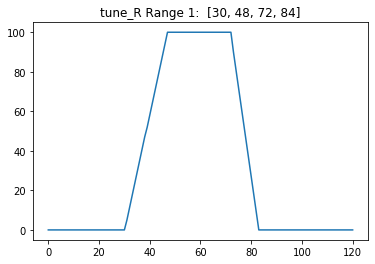

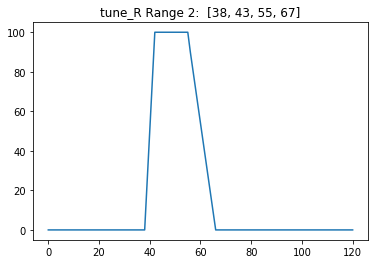

In [134]:
######---  Main  ---######
midi_file_name = gen_midi()

midi_play(midi_file_name)
midi_audio(midi_file_name)
midi_png(midi_file_name)